In [1]:
from hrr import hrri, convolve, LTM
import numpy as np
import random
import time
import math
import matplotlib
import matplotlib.pyplot as plt

from rl import *
from agent import RlAgent
from utils import display_progress

Using TensorFlow backend.


# 1D Maze

This problem requires the agent to locate the goal within a 1D maze. The maze will be of some size *n*, indicating the possible number of positions/states. Given a position *x*, the position to the left is *x-1*, and the position to the right is *x+1*. The maze is also cyclical, so position *0* is adjacent to position *n-1*.

This notebook contains several different variants of the 1D maze problem.

# Maze Agent Definitions

These are the maze agents defined. Each problem is designed to accept *any* given RL approach.

## Standard Maze Agent

Set a goal position and the agent will learn to find it using the given TD-learning algorithm. This is the most basic variation of the problem and is used as a learning proof-of-concept.

In [2]:
class MazeAgent(RlAgent):
    
    def __init__(self, rl, mazeSize, goal):
        super(MazeAgent, self).__init__(rl)
        self.__size = mazeSize
        self.__goal = goal
        
    def onBegin(self, state, startState = None):
        if startState() is not None:
            state(startState)
        else:
            state(random.randrange(self.__size))
        
    def onStep(self, state):
        if state() == self.__goal and self.stepCount() != 0:
            return False
        action = self.predict(f"s{state()}", ("left", "right"))
        if action == 0:
            state((state() - 1) % self.__size)
        else:
            state((state() + 1) % self.__size)
    
    def onFinish(self, state):
        if state() == self.__goal:
            self.reward(1.0)
        return self.stepCount()

## N-task Maze Agent

Rather than learning to solve a single goal, this agent can learn to solve multiple goals, provided it is given some indication of which goal to solve. While the agent doesn't *know* where the goal is, the goal is used to encode an HRR vector that is convolved with the current maze position in this implementation.

In [3]:
class NMazeAgent(RlAgent):
    
    def __init__(self, rl, mazeSize):
        super(NMazeAgent, self).__init__(rl)
        self.__size = mazeSize
        
    def onBegin(self, state = None, goal = None, goals = (0,)):
        if goal() is None:
            goal(goals()[random.randrange(len(goals()))])
        if state() is None:
            state(random.randrange(self.__size))
        
    def onStep(self, state, goal):
        if state() == goal() and self.stepCount() != 0:
            return False
        action = self.predict(f"s{state()}*g{goal()}", ("left", "right"))
        if action == 0:
            state((state() - 1) % self.__size)
        else:
            state((state() + 1) % self.__size)
    
    def onFinish(self, state, goal):
        if state() == goal():
            self.reward(1.0)
        return self.stepCount()

## Working Memory Maze Agent

This agent can solve a maze that contains multiple goals as before; but this agent utilizes working memory to do so. By giving the signal for the goal only at the very beginning of the episode, the agent will be require to *remember* this signal in order to find it. This is one of the basic demonstrations of the working memory concept.

In [147]:
class WmMazeAgent(RlAgent):
    
    def __init__(self, rl, mazeSize):
        super(WmMazeAgent, self).__init__(rl)
        self.__size = mazeSize
        self.actions = tuple('*'.join((m, d)) for m in ("protect", "store") for d in ("left", "right"))
        
    def onBegin(self, state = None, goal = None, goals = (0,), wm = None):
        if goal() is None:
            goal(goals()[random.randrange(len(goals()))])
        if state() is None:
            state(random.randrange(self.__size))
        
    def onStep(self, state, goal, wm):
        if state() == goal() and self.stepCount() > 0:
            if state() == goal():
                return False
            self.reward(-1, absorb=False)
        stateConv = self.stateConv(state, goal, wm)
        action = self.predict(stateConv, self.actions)
        self.move(state, action)
        self.updateWm(action, goal, wm)
    
    def onFinish(self, state, goal):
        if state() == goal():
            self.reward(0)
        return self.stepCount()
    
    def stateConv(self, state, goal, wm):
        conv = f"s{state()}"
        if self.stepCount() == 0: # The signal is on
            conv += f"*g{goal()}"
        if wm(): # There is a value in WM
            conv += f"*{wm()}"
        return conv
    
    def move(self, state, action):
        if action & 1: # Right
            state((state() + 1) % self.__size)
        else:
            state((state() - 1) % self.__size)
            
    def updateWm(self, action, goal, wm):
        if action & 2: # The action requests to store
            wm(f"g{goal()}_i" if self.stepCount() == 0 else None)

# Problem Solving

Below are some problem solving examples using the maze implementations defined above.

## Global Options

In [5]:
# Hard limit number of moves for a single episode
STEP_LIMIT = 100

## Utility Functions

In [6]:
def trainAgent(agent, *args, nEpochs=0, epsilon=0, simLimit=STEP_LIMIT, **kwargs):
    """Train the given agent for a fixed number of epochs"""
    s = time.time()
    for i in range(1, nEpochs+1):
        steps = agent.train(*args, epsilon=epsilon, simLimit=simLimit, **kwargs)
        display_progress((i)/nEpochs, f"Epoch: {i}/{nEpochs}")
    print(f"{agent.epoch()} took {time.time()-s:.2f} seconds")
    
def trainAgentConverge(agent):
    """Train the given agent until it can solve optimally"""
    pass

def plot(title, width, data, labels):
    t = np.arange(0, width+1, 1)
    fig, ax = plt.subplots()
    for i in range(len(data)):
        ax.plot(t, data[i], label=labels[i])
    ax.set(xlabel='Position (s)', ylabel='Expected Reward Q(s, a)',
           title=title)
    ax.grid()
    plt.legend()

## Standard Maze Agent

In [15]:
# Maze Settings
MAZE_SIZE = 20
GOAL      = 10

# Agent Settings
HRR_SIZE   = 512
LEARN_RATE = 0.05
EPSILON    = 0.1
DISCOUNT   = 0.75

# Q-learning Agent
ql = NQLearningNetwork(1, HRR_SIZE, LEARN_RATE, DISCOUNT)
qlAgent = MazeAgent(ql, MAZE_SIZE, GOAL)

# Double Q-learning Agent
dql = NQLearningNetwork(2, HRR_SIZE, LEARN_RATE, DISCOUNT)
dqlAgent = MazeAgent(dql, MAZE_SIZE, GOAL)

Epoch: 5000/5000
Progress: [####################] 100.00%
5000 took 154.00 seconds


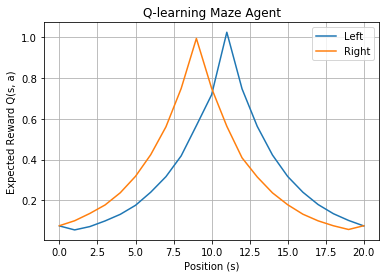

In [8]:
trainAgent(qlAgent, nEpochs=5000, epsilon=EPSILON, simLimit=STEP_LIMIT)
l = [ql.value(f"s{(i%MAZE_SIZE)}", "left") for i in range(MAZE_SIZE+1)]
r = [ql.value(f"s{(i%MAZE_SIZE)}", "right") for i in range(MAZE_SIZE+1)]
plot("Q-learning Maze Agent", MAZE_SIZE, (l, r), ("Left", "Right"))

Epoch: 5000/5000
Progress: [####################] 100.00%
5000 took 205.17 seconds


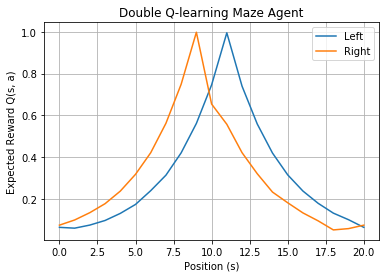

In [16]:
trainAgent(dqlAgent, nEpochs=5000, epsilon=EPSILON, simLimit=STEP_LIMIT)
l = [dql.averageValue(f"s{(i%MAZE_SIZE)}", "left") for i in range(MAZE_SIZE+1)]
r = [dql.averageValue(f"s{(i%MAZE_SIZE)}", "right") for i in range(MAZE_SIZE+1)]
plot("Double Q-learning Maze Agent", MAZE_SIZE, (l, r), ("Left", "Right"))

# N-task Maze Agent

In [107]:
# Maze Settings
MAZE_SIZE = 20

# Agent Settings
HRR_SIZE   = 1024
LEARN_RATE = 0.05
EPSILON    = 0.3
DISCOUNT   = 0.75

# Q-learning Agent
# Shown to converge with Size=10, HRR=1024, Learn=1, Epsilon=0.2, Discount=0.5
# Shown to converge with Size=20, HRR=1024, Learn=0.05, Epsilon=0.3, Discount=0.75, ~3k epochs
ntaskQl = NQLearningNetwork(1, HRR_SIZE, LEARN_RATE, DISCOUNT)
ntaskQlAgent = NMazeAgent(ntaskQl, MAZE_SIZE)

# Double Q-learning Agent
ntaskDql = NQLearningNetwork(2, HRR_SIZE, LEARN_RATE, DISCOUNT)
ntaskDqlAgent = NMazeAgent(ntaskDql, MAZE_SIZE)

Epoch: 500/500
Progress: [####################] 100.00%
3500 took 15.78 seconds


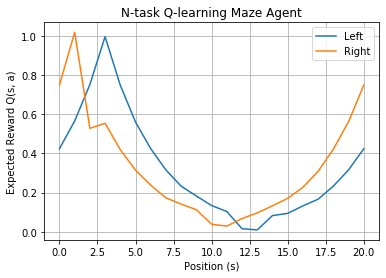

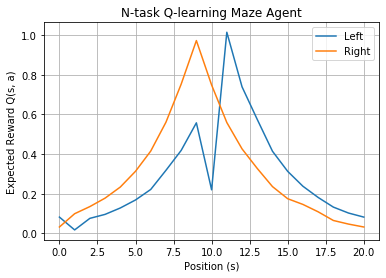

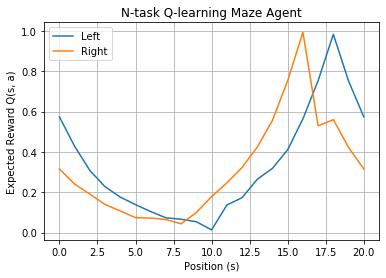

In [116]:
GOALS = (2, 10, 17)

trainAgent(ntaskQlAgent, goals=GOALS, nEpochs=500, epsilon=EPSILON, simLimit=STEP_LIMIT)
for goal in GOALS:
    l = [ntaskQl.value(f"s{(i%MAZE_SIZE)}*g{goal}", "left") for i in range(MAZE_SIZE+1)]
    r = [ntaskQl.value(f"s{(i%MAZE_SIZE)}*g{goal}", "right") for i in range(MAZE_SIZE+1)]
    plot("N-task Q-learning Maze Agent", MAZE_SIZE, (l, r), ("Left", "Right"))

Epoch: 500/500
Progress: [####################] 100.00%
6000 took 17.89 seconds


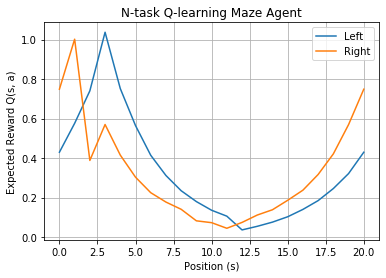

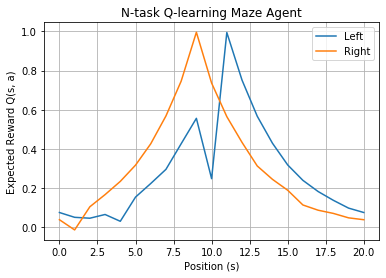

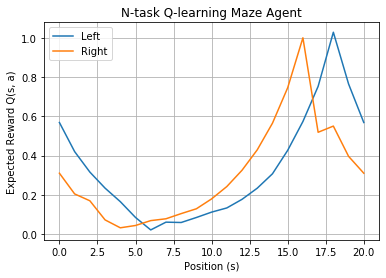

In [115]:
GOALS = (2, 10, 17)

trainAgent(ntaskDqlAgent, goals=GOALS, nEpochs=500, epsilon=EPSILON, simLimit=STEP_LIMIT)
for goal in GOALS:
    l = [ntaskDql.averageValue(f"s{(i%MAZE_SIZE)}*g{goal}", "left") for i in range(MAZE_SIZE+1)]
    r = [ntaskDql.averageValue(f"s{(i%MAZE_SIZE)}*g{goal}", "right") for i in range(MAZE_SIZE+1)]
    plot("N-task Q-learning Maze Agent", MAZE_SIZE, (l, r), ("Left", "Right"))

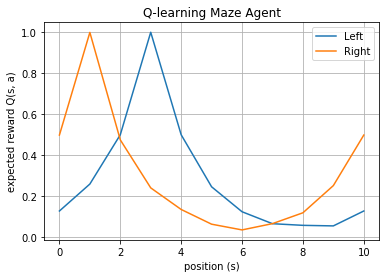

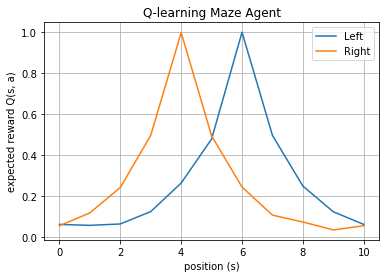

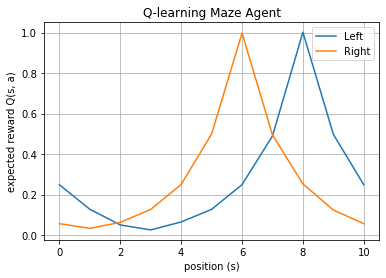

In [18]:
size = 10
t = np.arange(0, size+1, 1)
for goal in goals:
    fig, ax = plt.subplots()
    ax.plot(t, [agent2.value(f"state{(i%size)}*goal{goal}", "left") for i in range(size+1)], label="Left")
    ax.plot(t, [agent2.value(f"state{(i%size)}*goal{goal}", "right") for i in range(size+1)], label="Right")
    ax.set(xlabel='position (s)', ylabel='expected reward Q(s, a)',
           title='Q-learning Maze Agent')
    ax.grid()
    plt.legend()

# Working Memory 1D-Maze

In [160]:
# Maze Settings
MAZE_SIZE = 20

# Agent Settings
HRR_SIZE   = 4096
LEARN_RATE = 1.0
EPSILON    = 0.25
DISCOUNT   = 0.75

# Q-learning Agent
# Shown to converge with Size=10, Learn=1, HRR=4096, Epsilon=0.3, Discount=0.5
# Shown to converge with Size=20, Learn=1, HRR=4096, Epsilon=0.25, Discount=0.75
wmQl = NQLearningNetwork(1, HRR_SIZE, LEARN_RATE, DISCOUNT)
wmQlAgent = WmMazeAgent(wmQl, MAZE_SIZE)

# Double Q-learning Agent
wmDql = NQLearningNetwork(2, HRR_SIZE, LEARN_RATE, DISCOUNT)
wmDqlAgent = WmMazeAgent(wmDql, MAZE_SIZE)

In [181]:
GOALS = (0, 10)

trainAgent(wmQlAgent, goals=GOALS, nEpochs=4000, epsilon=EPSILON, simLimit=STEP_LIMIT)

Epoch: 4000/4000
Progress: [####################] 100.00%
10000 took 474.79 seconds


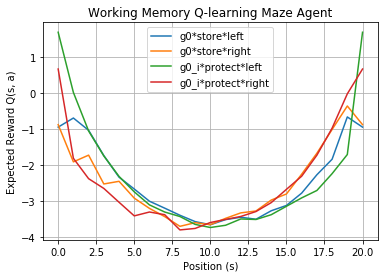

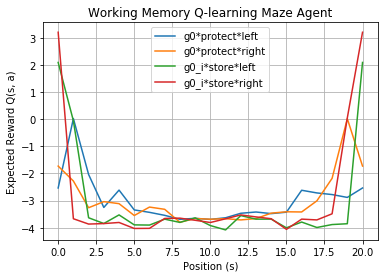

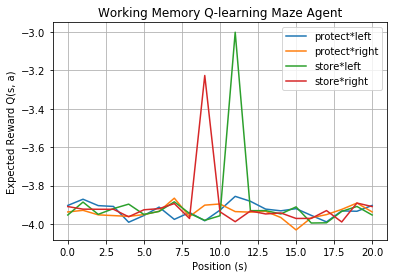

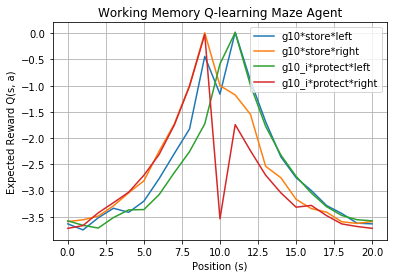

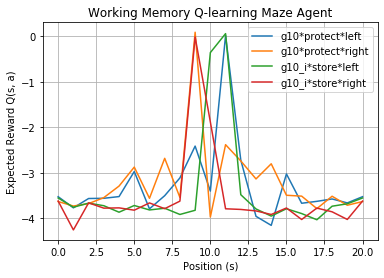

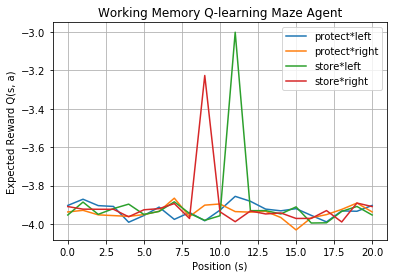

In [174]:
for goal in GOALS:
    for goalset in ((f"*g{goal}*store", f"*g{goal}_i*protect"), (f"*g{goal}*protect", f"*g{goal}_i*store"), ("*protect", "*store")):
        data, labels = [], []
        for goalr in goalset:
            for action in ("left", "right"):
                labels.append(f"{goalr[1:]}*{action}")
                data.append([wmQl.averageValue(f"s{i%MAZE_SIZE}{goalr}", action) for i in range(MAZE_SIZE+1)])
        plot("Working Memory Q-learning Maze Agent", MAZE_SIZE, data, labels)

In [179]:
GOALS = (0, 10)

trainAgent(wmDqlAgent, goals=GOALS, nEpochs=6000, epsilon=EPSILON, simLimit=STEP_LIMIT)

Epoch: 6000/6000
Progress: [####################] 100.00%
12000 took 881.29 seconds


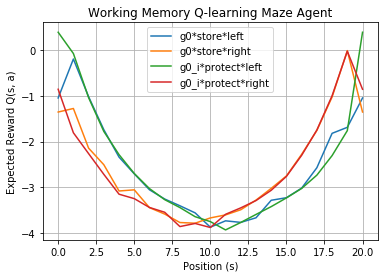

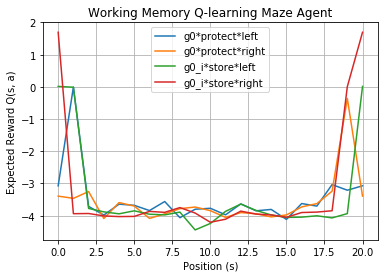

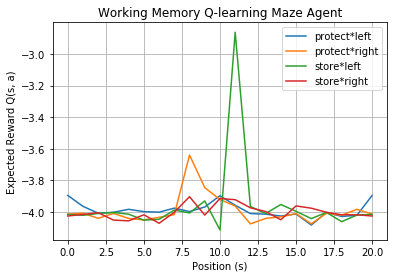

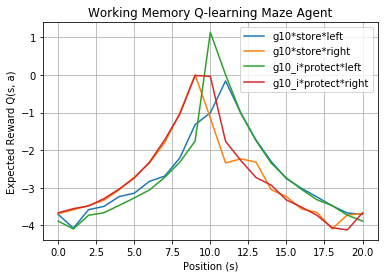

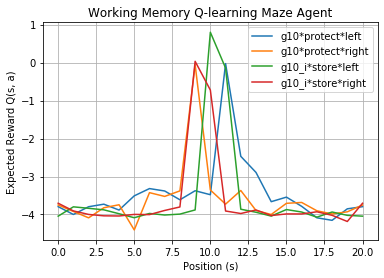

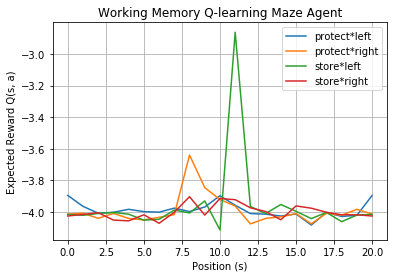

In [180]:
for goal in GOALS:
    for goalset in ((f"*g{goal}*store", f"*g{goal}_i*protect"), (f"*g{goal}*protect", f"*g{goal}_i*store"), ("*protect", "*store")):
        data, labels = [], []
        for goalr in goalset:
            for action in ("left", "right"):
                labels.append(f"{goalr[1:]}*{action}")
                data.append([wmDql.averageValue(f"s{i%MAZE_SIZE}{goalr}", action) for i in range(MAZE_SIZE+1)])
        plot("Working Memory Q-learning Maze Agent", MAZE_SIZE, data, labels)

In [ ]:
for goal in goals:
    for start in range(0, size):
        optimal = 2 if start == goal else min(abs(goal - start), size - abs(goal - start))
        print(goal, start)
        result = wmAgent.run(goal, epsilon=0, startState=start, learn=False)
        if result - optimal:
            print(f"Not optimal; Goal: {goal}, Start: {start}, Optimal: {optimal}, Actual: {result}")

In [651]:
size = 10
dqWmAgent = DqMazeWmAgent(size, 1000, discountFactor=0.5, learnRate=1.0)
totalEpochs = 0

In [658]:
goals = (2,7)
nEpochs = 5000
for i in range(nEpochs):
    totalEpochs += 1
    s = time.time()
    steps = dqWmAgent.run(goals[random.randrange(len(goals))], epsilon = 0.3)
    display_progress(i/(nEpochs - 1), f"Epoch: {i}/{nEpochs}")
print("Total Epochs:", totalEpochs)

Epoch: 4999/5000
Progress: [####################] 100.00%
Total Epochs: 21000


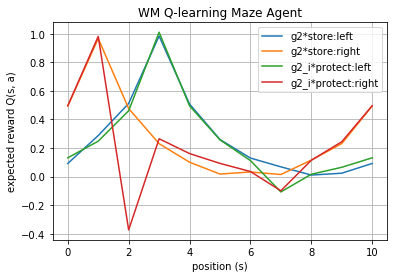

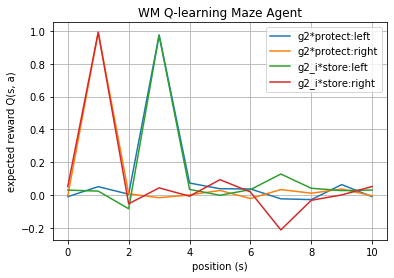

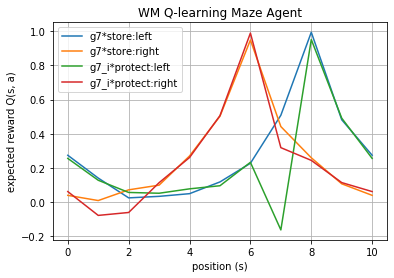

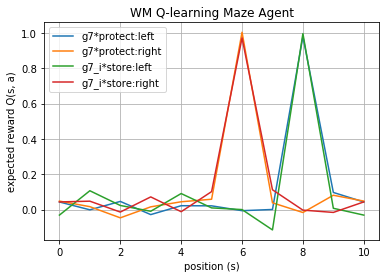

In [659]:
t = np.arange(0, size+1, 1)
for goal in goals:
    for goalset in ((f"*g{goal}*store", f"*g{goal}_i*protect"), (f"*g{goal}*protect", f"*g{goal}_i*store")):
        fig, ax = plt.subplots()
        for goalr in goalset:
            for action in ("left", "right"):
                ax.plot(t, [dqWmAgent.averageValue(f"s{i%size}{goalr}", action) for i in range(size+1)], label=f"{goalr[1:]}:{action}")
        ax.set(xlabel='position (s)', ylabel='expected reward Q(s, a)', title='WM Q-learning Maze Agent')
        ax.grid()
        plt.legend()

In [661]:
for goal in goals:
    for start in range(0, size):
        optimal = 2 if start == goal else min(abs(goal - start), size - abs(goal - start))
        print(goal, start)
        result = dqWmAgent.run(goal, epsilon=0, startState=start, learn=False)
        if result - optimal:
            print(f"Not optimal; Goal: {goal}, Start: {start}, Optimal: {optimal}, Actual: {result}")

2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9


# Double Q-learning

In [578]:
class DQMazeAgent(NQLearningNetwork):
    
    def __init__(self, mazeSize, hrrSize, learnRate = 1, discountFactor = 0.5, verbose = False):
        super(DQMazeAgent, self).__init__(2, hrrSize, learnRate, discountFactor, verbose)
        self.__size = mazeSize
        self.__goal = 0
        
    def run(self, epsilon = 0.1, startState = None):
        self.newEpisode()
        state = random.randrange(self.__size) if startState is None else startState
        while state != self.__goal or self.stepCount() == 0:
            action = self.predict(f"s{state}", ("left", "right"), epsilon, learn=True)
            if action == 0:
                state = (state - 1) % self.__size
            else:
                state = (state + 1) % self.__size
        self.reward(1.0)
        return self.stepCount()
    
    def goal(self):
        return self.__goal
    
    def setGoal(self, goal):
        self.__goal = goal

In [618]:
goal = 5

dqAgent = DQMazeAgent(10, 100, verbose=False)
dqAgent.setGoal(goal)
totalEpochs = 0

In [626]:
nEpochs = 1000
s = time.time()
for i in range(nEpochs):
    totalEpochs += 1
    steps = dqAgent.run(0.2)
    display_progress(i/(nEpochs - 1), f"Epoch: {i}/{nEpochs}")
print(f"{totalEpochs} took {time.time()-s:.2f} seconds")

Epoch: 999/1000
Progress: [####################] 100.00%
4000 took 21.14 seconds


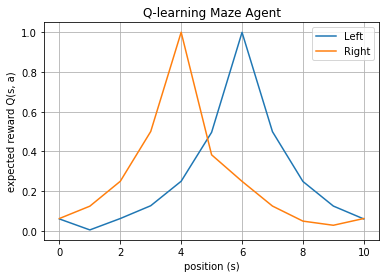

In [627]:
size = 10
t = np.arange(0, size+1, 1)
fig, ax = plt.subplots()
ax.plot(t, [dqAgent.averageValue(f"s{(i%size)}", "left") for i in range(size+1)], label="Left")
ax.plot(t, [dqAgent.averageValue(f"s{(i%size)}", "right") for i in range(size+1)], label="Right")
ax.set(xlabel='position (s)', ylabel='expected reward Q(s, a)',
       title='Q-learning Maze Agent')
ax.grid()
plt.legend()

1 5 2


In [6]:
def test(a, b, c=15, d="Test"):
    print(a(), b(), c(c()+1), d())
    
sm = StateMap(test)

In [12]:
sm.invoke(test, 1, 2)

1 2 21 Test


In [7]:
from inspect import signature, Parameter

s = signature(test)
s.parameters
Parameter.empty

inspect._empty

IndexError: pop from empty list

[2, 3]